<a href="https://colab.research.google.com/github/kerryback/Classic_Tests/blob/main/3_Fama_MacBeth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overview

We're going to form portfolios based on rolling-window beta estimates.  Then, we we will estimate the portfolio betas and residual standard deviations, again using rolling-window regressions. Then, we will run regressions on the cross-sections of portfolios to determine whether beta, squared beta, and residual standard deviation predict returns.  This is the Fama-MacBeth test of the CAPM.

In [1]:
!pip install --upgrade statsmodels

     |████████████████████████████████| 9.8 MB 4.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader as pdr
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read the file created and saved in the Black_Jensen_Scholes notebook.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/crsp_compustat_example2.csv', parse_dates=['date'])
df.date = df.date.dt.to_period('M')
df = df.sort_values(by=['permno','date'])

Mounted at /content/drive


# Sort into 20 portfolios each month and compute value-weighted returns

In [20]:
df['group'] = df.groupby('date').beta.apply(lambda x: pd.qcut(x,20,labels=range(1,21)))
df2 = df.groupby(['date','group']).apply(lambda d: (d.me*d.ret).sum() / d.me.sum())
df2 = pd.DataFrame(df2).reset_index()
df2.columns = ['date','group','ret']
df = df.drop(columns=['group'])

# Merge market excess return and risk-free rate

In [21]:
ff = pdr('F-F_Research_Data_Factors','famafrench',start='1962-01-01')[0] / 100
df2 = df2.merge(ff[['Mkt-RF','RF']],left_on='date',right_index=True,how='left')

# Rolling betas and idiosyncratic volatilities of portfolios

Run rolling window regressions and keep betas and residual standard deviations.

In [22]:
def rollingReg(d) :
    try :
        result = RollingOLS(d.ret-d.RF,sm.add_constant(d['Mkt-RF']),window=60,min_nobs=60).fit()
        df = pd.DataFrame(result.params['Mkt-RF'])
        df.columns = ['beta']
        df['rstd'] = np.sqrt(result.mse_resid)
        df.index = d.date
        return df
    except :
        return pd.DataFrame(np.nan,index=d.date,columns=['beta','rstd'])
data = df2.groupby('group').apply(rollingReg)
df2 = df2.merge(data,left_on=['group','date'],right_index=True,how='inner')

# shift beta and rstd so they are from the prior 60 months
for col in ['beta','rstd'] :
    df2[col] = df2[col].shift()
df2 = df2.dropna(subset=['beta','rstd','ret'],how='any')

# Fama-MacBeth regressions

Run a cross-sectional regression (cross-section = 20 portfolios) each month on beta, squared beta, and residual standard deviation:

$$r_{pt} = \alpha_t + \gamma_{1t} \hat{\beta}_{pt} + \gamma_{2t}\hat{\beta}_{pt}^2 + \gamma_{3t}\hat{\sigma}_{pt} + e_{pt}$$

In [23]:
df2['beta2'] = df2['beta']**2
coefs = df2.groupby('date').apply(lambda d: sm.OLS(d.ret,sm.add_constant(d[['beta','beta2','rstd']])).fit().params) 

# Test the CAPM

According to the CAPM, the coefficient on $\beta$ should be the market risk premium, and the coefficients on $\beta^2$ and the residual standard deviation should be zero.  We run $t$ tests of the nulls that the coefficients are zero.  We cannot reject the null hypotheses that the coefficients on $\beta^2$ and the residual standard deviation are zero.  Furthermore, the mean $\beta$ coefficient is almost exactly equal to the mean market risk premium over this sample, as predicted by the CAPM.  

In [29]:
from scipy.stats import ttest_1samp as ttest

stats = pd.DataFrame(dtype=float,index=coefs.columns,columns=['mean','tstat','pval'])
for coef in coefs.columns :
    t, p = ttest(coefs[coef],0)
    stats.loc[coef,'mean'] = coefs[coef].mean()
    stats.loc[coef,'tstat'] = t
    stats.loc[coef,'pval'] = p
stats.round(4)

,mean,tstat,pval
const,0.0072,0.8860,0.3760
beta,0.0064,0.4592,0.6462
beta2,-0.0033,-0.5390,0.5901
rstd,-0.0418,-0.4000,0.6893


In [31]:
round(coefs.beta.mean(),4)

0.0064

# Visualizing the test

We have cross-sectional regression coefficients each month.  The following adds up the beta coefficient over time and also adds up the market excess return over time.  The CAPM predicts that the two plots should grow at the same average rate (the average beta coefficient should be the market risk premium).  Because the two plots end at the same place, they do grow at the same average rates for this sample.

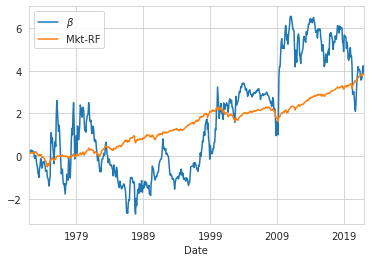

In [34]:
coefs['beta'].cumsum().plot(label=r'$\beta$')
ff['Mkt-RF'].loc[coefs.index].cumsum().plot(label='Mkt-RF')
plt.legend()